In [149]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime, timedelta
import gdal
import scipy as sp

import cartopy.crs as ccrs

In [160]:
s_time = datetime(2019,1,26,0)
e_time = datetime(2020,2,8,0)

lat0 = -10
lat1 = -30
lon0 = 135
lon1 = 154
res = 0.05

In [161]:
# path for HIMAWARI (after running Pablos algorthim to stack nc files)
path_him = '/g/data1a/oe9/user/ds4491/Him_Extract_Test/HIM8_TWNV_SE_2019.nc'
path_awap = '/g/data1a/oe9/user/data/gridded_rainfall_0.05deg/rain_day_2019_Actual_day.nc'

In [162]:
him = xr.open_dataset(path_him)

In [163]:
him['f1'] = (him['B14']<=230)
him['f2'] = (him['B8']-him['B12'])>= -10
him['mask_n'] = him['f1']*1 + him['f2']*1

In [164]:
him['f3'] = (him['B8']-him['B10'])>= -7
him['f4'] = (him['B16']-him['B14'])>= -5
him['mask_n'] = him['mask_n']*1 + him['f3']*1 + him['f4']*1

In [165]:
him['f5'] = (him['B15']-him['B14'])>= -1.5
him['f6'] = (him['B11']-him['B14'])>= 2
him['mask_n'] = him['mask_n']*1 + him['f5']*1 + him['f6']*1

In [166]:
him['f7'] = (((him['B8']+him['B13'])/2)-273) <= -35
him['mask_n'] = him['mask_n'] + him['f7']*1

In [167]:
him['mask']= him['mask_n']>=5

In [170]:
him2 = him.copy()
him2.time.values = np.round(him2.time)
index_time = np.unique(him2.time.values, return_index=True)
him3=him2[['mask']].isel(time = index_time[1]).copy()

lat = him3['lat'].values
lon = him3['lon'].values
time = him3['time'].values

for ii in np.arange(len(him3.time.values)):    
    mask = np.any(np.stack(him2['mask'].sel(time=him3.time.values[ii]).values),axis = 0)
    if ii==0:
        mask_all = mask.copy()
        mask_all = np.expand_dims(mask_all,axis=0)
    else:
        mask = np.expand_dims( mask,axis=0)
        mask_all= np.append( mask_all,mask,axis=0)

him4 = xr.Dataset({'mask': (['time', 'lat', 'lon'],  mask_all)},coords={ 'lon': lon, 'lat': lat, 'time': time})
him4

<xarray.Dataset>
Dimensions:  (lat: 1000, lon: 1000, time: 15)
Coordinates:
  * lon      (lon) float64 135.0 135.0 135.1 135.1 ... 154.9 154.9 155.0 155.0
  * lat      (lat) float64 -10.01 -10.03 -10.05 -10.07 ... -29.95 -29.97 -29.99
  * time     (time) float64 2.019e+07 2.019e+07 ... 2.019e+07 2.019e+07
Data variables:
    mask     (time, lat, lon) bool True True True True ... True False False

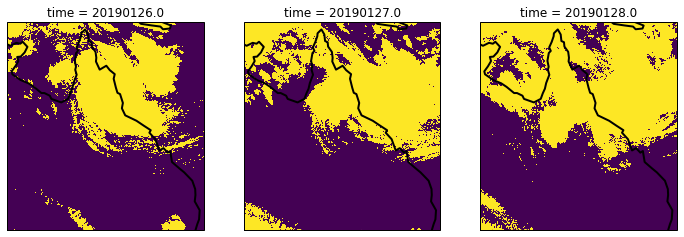

In [171]:
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 3) # plot 3 axes along one row with three columns

# add first axis
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
him4['mask'].isel(time=0).plot(ax=ax1,transform=ccrs.PlateCarree(),add_colorbar=False) # don't plot colorbar
ax1.coastlines(linewidth=2); ax1.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())
him4['mask'].isel(time=1).plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.coastlines(linewidth=2); ax2.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax3 = fig.add_subplot(gs[0, 2],projection=ccrs.PlateCarree())
him4['mask'].isel(time=2).plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False)
ax3.coastlines(linewidth=2); ax3.set_extent([lon0,lon1,lat1,lat0])

In [172]:
awap= xr.open_dataset(path_awap)
awap = awap.sel(time = slice(s_time,e_time),latitude = slice(lat0,lat1),longitude= slice(lon0,lon1))
awap['rain_day'].isel(time=0)

<xarray.DataArray 'rain_day' (latitude: 401, longitude: 381)>
[152781 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 2019-01-26
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 ... -29.9 -29.95 -30.0
  * longitude  (longitude) float64 135.0 135.1 135.1 135.2 ... 153.9 153.9 154.0
Attributes:
    name:           rain_day
    standard_name:  lwe_thickness_of_precipitation_amount
    long_name:      Daily Rainfall
    units:          mm

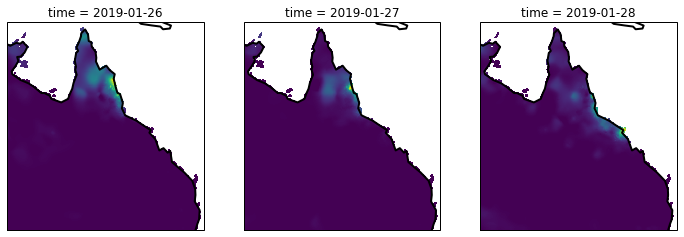

In [173]:
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 3) # plot 3 axes along one row with three columns

# add first axis
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=0).plot(ax=ax1,transform=ccrs.PlateCarree(),add_colorbar=False) # don't plot colorbar
ax1.coastlines(linewidth=2); ax1.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=1).plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.coastlines(linewidth=2); ax2.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax3 = fig.add_subplot(gs[0, 2],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=2).plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False)
ax3.coastlines(linewidth=2); ax3.set_extent([lon0,lon1,lat1,lat0])

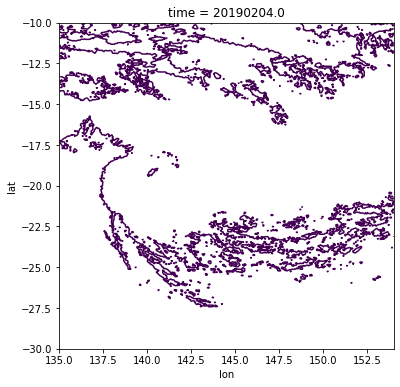

In [174]:
awap_lat = awap['latitude'].data
awap_lon = awap['longitude'].data

him4['mask']=him4['mask']*1
mask_resamp = him4.mask.interp(lat = awap_lat, lon = awap_lon)
mask_resamp.isel(time=10).plot.contour(levels=1,figsize=(6,6))

In [175]:
# make mask cmap
mask_cmap = colors.ListedColormap(['#FFFFFF00','#A9A9A910'])
bounds=np.arange(-1, 1, 3).tolist()

Text(0, 0.5, 'Latitude $(^\\circ)$')

/g/data/oe9/software/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


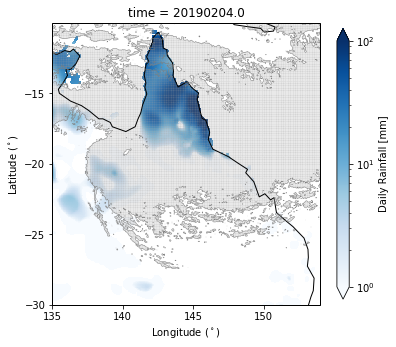

In [176]:
# plot mask on awap
awap_lat = awap['latitude'].data
awap_lon = awap['longitude'].data
him4['mask']=him4['mask']*1
mask_resamp = him4.mask.interp(lat = awap_lat, lon = awap_lon)
# plot contour over awap 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree(),cmap="Blues",\
                                   norm=colors.LogNorm(vmin=1,vmax=100),cbar_kwargs={"shrink":0.83}) # don't plot colorbar
mask_resamp.isel(time=10).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=mask_cmap,add_colorbar=False)
mask_resamp.isel(time=10).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=1,colors="grey",linewidths=0.5)

ax.coastlines(linewidth=1)
ax.set_extent([lon0,lon1,lat1,lat0])
ax.set_xticks([i for i in np.arange(lon0,lon1,5)],crs=ccrs.PlateCarree())
ax.set_yticks([i for i in np.arange(lat1,lat0,5)],crs=ccrs.PlateCarree())
ax.set_xlabel("Longitude $(^\circ)$")
ax.set_ylabel("Latitude $(^\circ)$")